# 3_Building footprints classification

Notebook for the 3rd pipeline - building footprints classification. In this notebook, we would like to test the 4-step process:
1. Generate additional features for clustering (rectangularity, polygon turning functions, proximity matrix)
1. Apply Tobler's geography law into clustering footprints (objects that are closed together --> same functions | near things are more relevant than far things)
    1. Proximity-based grouping footprints into building blocks (DBSCAN)
    1. Geography law apply: find footprints with similar shape (turning func, rectangularity) + size (total_area) ==> get majority of types
        1. Same building block
        1. Same area
    1. Apply statistical analysis results to categorize left-over footprints

## Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

d:\programdata\anaconda3\envs\phoenix\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import pandas as pd
import numpy as np
import sys
import os
import glob
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import igraph

from geopandas import GeoDataFrame
from pyrosm import OSM

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
# Self-made modules
import helpers as hp
import gemeindeverz

In [5]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Inputs
Define inputs path

In [6]:
buildings_int_path = '../data/02_intermediate/buildings_data/'
plz_ags_csv = '../data/01_raw/zuordnung_plz_ort_landkreis.csv'

# Demographics
ags_living_csv = '../data/01_raw/de_living_2019.csv'
ags_population_csv = '../data/01_raw/de_population_2019.csv'

# Community directory dataframe
GV_path = '../data/01_raw/GV/GV100AD_301120.asc'

buildings_int_location = '../data/02_intermediate/buildings_data/'

Demographics data

In [7]:
ags_living = pd.read_csv(ags_living_csv, 
                         sep = ';', 
                         encoding = 'cp1250', 
                         dtype= {'1_Auspraegung_Code':str},
                         low_memory = False)
ags_population = pd.read_csv(ags_population_csv, 
                             sep = ';', 
                             dtype= {'1_Auspraegung_Code':str},
                             encoding = 'cp1250', 
                             low_memory = False)


Geographic data

In [8]:
# Contain local AGS codes (no regional)
plz_ags = pd.read_csv(plz_ags_csv, dtype= {'plz': str, 'ags': str})
plz_ags.shape

(12883, 4)

In [9]:
# Use this file to manually get ags code for region available on Geofabrik (inside state)
# com_dir_df = gemeindeverz.einlesen(GV_path)



## Building blocks segmentation with (H)DBSCAN

In the paper ["Proximity-based grouping of buildings in urban blocks"](https://www.researchgate.net/publication/271901065_Proximity-based_grouping_of_buildings_in_urban_blocks_A_comparison_of_four_algorithms), the authors used 2 different approaches to evaluate 4 algorithms in clustering buildings into urban blocks. It concludes that DBSCAN (Density-based spatial clustering of applications with noise) together with ASCDT (An adaptive spatial clustering algorithm based on delaunay triangulation) performed best and their degree of complexity is not hard to implement. Thus, in this project, I implemented DBSCAN to cluster our OSM footprints into segments.

### Reason not to use K-means (bonus)

When think of clustering, k-means usually pops right up as the first answer. As the algorithm itself, k-means is designed to minimize variance. 

Since the data is in latitude, longitude format ==> not **linear**, worst case is k-means will never converge (even with Haversine distance). To circumvent this problem, we should use an algorithm that can handle arbitrary distance functions, in particular geodetic distance functions such as Hierarchical clustering, PAM, CLARA, OPTICS and DBSCAN.

(inspired from [*])



### DBSCAN

> It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.[*]

More details can be found here in this [NICE article](https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html) from KDnuggets

#### Algorithm inputs
For our project, we need to generate a **proximity matrix** for all building footprints in the area. Since we have already gathered and cleaned building objects data from ~10k municipalities in Germany (refer to the previous article), it is better to keep the building blocks grouping it the same granularity level (a.k.a municipality-level - AGS key)

There are 2 parameters for DBSCAN we need to set *Epsilon* and *MinPts*. We will start with the baseline from the paper with *Epsilon* = 3 and *MinPts* = 2 then fine-tune them to get optimized values

> If “MinPts (minimum points)” = 4, any 4 or more points within the epsilon distance away from each other will be considered a cluster.

### HDBSCAN
HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander[*]. It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. Since clusters formed are not radius-based, they can be in non-circular format. Hence, it is more suitable for geo-analytics considering footprints boundaries are not in circular shape.And this is the algorithm we will use to group building footprints together.

Another good read to understand HDBSCAN better from [Author Name]'s article is here https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e

### References
[*] Ester, M. (2019). A density-based algorithm for discovering clusters in large spatial databases with noise. [online] Psu.edu. Available at: https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.121.9220 [Accessed 2 Jan. 2021].

[*] McInnes, L., Healy, J. and Astels, S. (2017). hdbscan: Hierarchical density based clustering. [online] ResearchGate. Available at: https://www.researchgate.net/publication/315508524_hdbscan_Hierarchical_density_based_clustering [Accessed 6 Jan. 2021].

[*] Clustering geo location coordinates (lat,long pairs (2014). Clustering geo location coordinates (lat,long pairs). [online] Data Science Stack Exchange. Available at: https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs [Accessed 6 Jan. 2021].



### Group AGS into Landkreis (1 level up)

Currently AGS key (8-digit) is structured as follow:

![AGS definition](../docs/AGS_definition.png)




In [10]:
# Get test AGS
ags_key = '09184123' # Haar

regex = re.compile(f'(buildings_ags_{ags_key})')

# Create district building dataframe
li = []
for root, dirs, files in os.walk(buildings_int_location):
    for file in files:
        if regex.match(file):
            print(file)
            ags_df = pd.read_csv(os.path.join(buildings_int_location,file), 
                             index_col=None, header=0)
            li.append(ags_df)

ags_df = pd.concat(li, axis=0, ignore_index=True)
ags_df.shape

buildings_ags_09184123.csv


(3969, 18)

## HDBSCAN for grouping building blocks

In [11]:
# ## HDBSCAN
# points = np.array([[lat1, lon1], [lat2, lon2], ...])
# rads = np.radians(points)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=N, metric='haversine')
# cluster_labels = clusterer.fit_predict(points)

In [12]:
import hdbscan

In [71]:
# Setting up coordinate matrix
coord_mat = np.array(ags_df[['center.lat','center.lon']])
rads = np.radians(coord_mat)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, 
                            metric='haversine',
                           min_samples = 2)
cluster_labels = clusterer.fit_predict(coord_mat)

In [72]:
cluster_res = pd.DataFrame(cluster_labels, columns = {'building_block'})
cluster_res.head()

,building_block
0,8
1,8
2,-1
3,-1
4,-1


In [73]:
pd.DataFrame(cluster_labels, columns = {'group'}).groupby('group').size()

group
-1      480
 0       19
 1      168
 2      319
 3       69
 4      343
 5       20
 6       36
 7       23
 8       10
 9       12
 10      34
 11      24
 12      59
 13      13
 14      10
 15      28
 16      14
 17      17
 18      15
 19      24
 20     127
 21      10
 22      17
 23      29
 24      26
 25      21
 26      10
 27      21
 28      11
 29      12
 30      19
 31      19
 32      65
 33      12
 34      11
 35      60
 36      11
 37      19
 38      11
 39      19
 40      19
 41      14
 42      56
 43      14
 44      19
 45      14
 46      22
 47      55
 48      65
 49      17
 50      12
 51      14
 52      14
 53      18
 54      22
 55      11
 56      28
 57      17
 58      46
 59      13
 60      32
 61      68
 62      11
 63      21
 64      23
 65      18
 66      19
 67      10
 68      11
 69      38
 70      10
 71      21
 72      16
 73      11
 74      14
 75      17
 76      27
 77      37
 78      16
 79      33
 80      12
 81      1

In [74]:
ags_df.shape

(3969, 18)

In [75]:
ags_final = ags_df[['id','building_types','geometry','center.lat','center.lon']].join(cluster_res)

In [76]:
# Compare with building_types (naive classification)
ags_final.head()

,id,building_types,geometry,center.lat,center.lon,building_block
0,17740278,public,"POLYGON ((11.7285854 48.1154755, 11.7285528 48.1154033, 11.7283878 48.1150377, 11.728875 48.1149396, 11.7288952 48.1149356, 11.7290929 48.1153734, 11.7287233 48.1154478, 11.7285854 48.1154755))",48.115206,11.728740,8
1,17740279,to_be_classified,"POLYGON ((11.7282493 48.1150021, 11.7287507 48.1149024, 11.7287133 48.1148185, 11.7285527 48.1144583, 11.7280512 48.114558, 11.7282493 48.1150021))",48.114730,11.728401,8
2,17740280,residential,"POLYGON ((11.7272223 48.1144978, 11.7273687 48.1144678, 11.7273909 48.1145163, 11.7280163 48.1143883, 11.7279674 48.1142816, 11.7281206 48.1142503, 11.7281816 48.1142651, 11.7280377 48.113942, 11.7279397 48.1140127, 11.7271174 48.1141809, 11.7271818 48.1143212, 11.7271448 48.1143287, 11.7272223 48.1144978))",48.114229,11.727650,-1
3,23146869,commercial,"POLYGON ((11.7213533 48.1090135, 11.7212886 48.1089319, 11.7212193 48.1089141, 11.7210976 48.1089622, 11.7210789 48.1089396, 11.7210448 48.1088927, 11.7210225 48.1088635, 11.7212188 48.1087956, 11.7208911 48.1083816, 11.7214465 48.1081855, 11.7215296 48.1082905, 11.7216129 48.1082611, 11.7219356 48.1086687, 11.7218809 48.108688, 11.7218399 48.1087025, 11.7219261 48.1088113, 11.7213533 48.1090135))",48.108599,11.721413,-1
4,24813100,to_be_classified,"POLYGON ((11.7432826 48.1112782, 11.7425555 48.1108021, 11.7430603 48.1104584, 11.7433415 48.1106425, 11.7431811 48.1107517, 11.7431105 48.1107055, 11.7429881 48.1107888, 11.7435046 48.1111271, 11.7432826 48.1112782))",48.110868,11.743030,-1


In [77]:
ags_final['building_block'] = ags_final['building_block'].astype(str)

In [78]:
# Plot
df = ags_final

In [79]:
from shapely import wkt
# Filter out NaN
df = df[df.geometry.isna() == False].reset_index(drop = True)

# Convert geometry to GeoSeries
df['geometry'] = df['geometry'].apply(wkt.loads)
# Convert to GeoPandas type
df_geo = GeoDataFrame(df, geometry='geometry')

In [80]:
df_geo = hp._swap_2_cols(df_geo, 'id','center.lon')
df_geo = hp._swap_2_cols(df_geo, 'building_types','center.lat')

df_geo.rename(columns = {'center.lat':'lat',
                        'center.lon':'lon'}, inplace = True)

In [81]:
plt.rcParams['axes.facecolor'] = 'white'

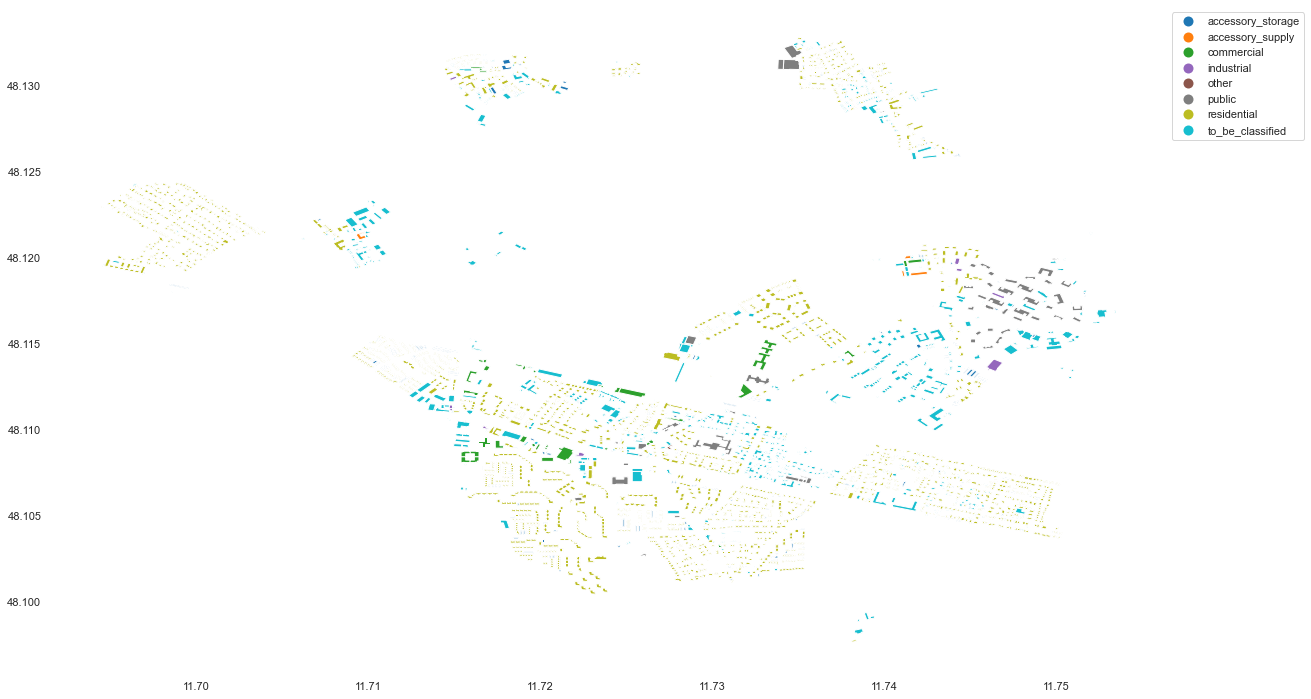

In [84]:
# Plot
ax =   df_geo.plot(column='building_types', 
                   markersize=3, 
                   figsize=(20,20), 
                   legend=True, 
                   legend_kwds=dict(loc='upper left', ncol=1, bbox_to_anchor=(1, 1)))

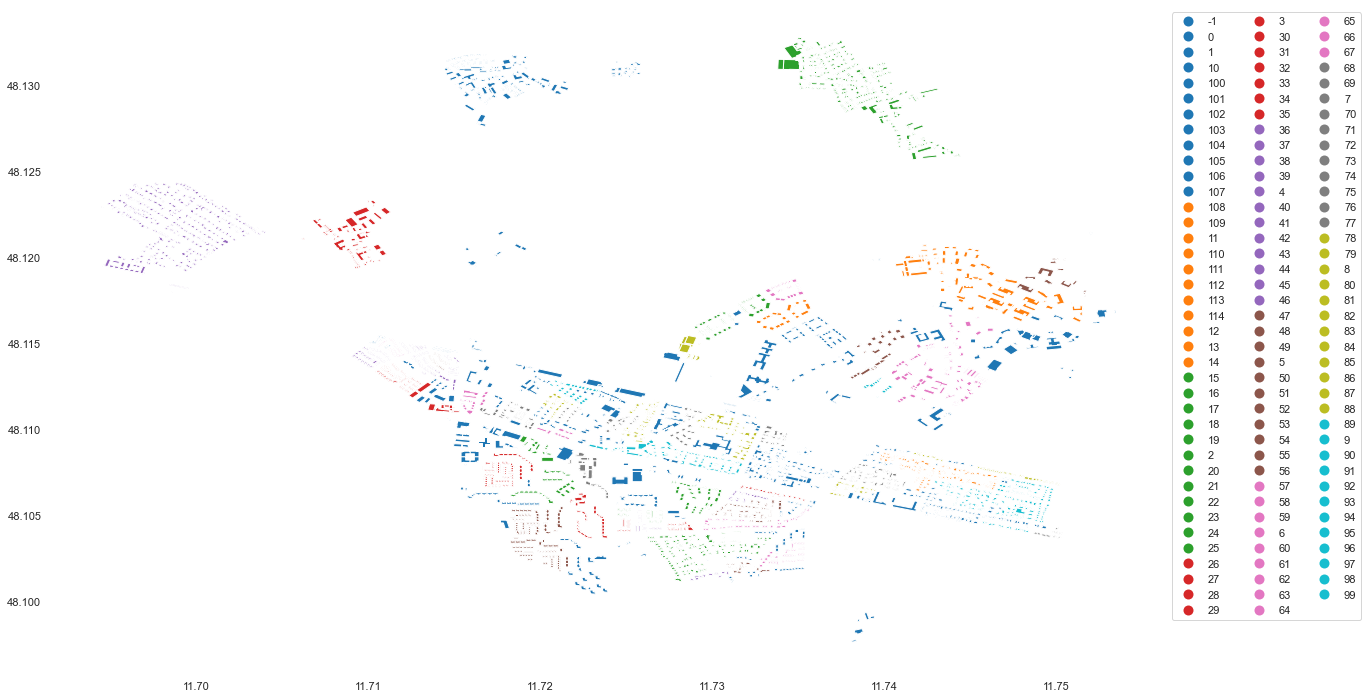

In [86]:
# Plot
ax =   df_geo.plot(column='building_block', 
                   markersize=3, 
                   figsize=(20,20), 
                   legend=True, 
                   legend_kwds=dict(loc='upper left', ncol=3, bbox_to_anchor=(1, 1)))

# DEV

In [ ]:
from numpy import array, zeros
from math import radians, cos, sin, asin, sqrt

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [ ]:
# Haverine distance matrix
N = coord_mat.shape[0]
distance_matrix = zeros((N, N))
for i in range(N):
    for j in range(N):
        lati, loni = coord_mat[i]
        latj, lonj = coord_mat[j]
        distance_matrix[i, j] = haversine(loni, lati, lonj, latj)
        distance_matrix[j, i] = distance_matrix[i, j]

In [ ]:
# # euclidean distance
# from scipy.spatial.distance import squareform 
# from scipy.spatial.distance import pdist

# array = pdist(coord_mat)

# dist_matrix = squareform(array)

## [SKIP] AGS district (memory issue)

In [ ]:
plz_ags['ags_district'] = plz_ags['ags'].apply(lambda x: hp._left(x,5))

In [ ]:
# Group to get only district-level ==> ~ 400 districts
plz_ags_dist = plz_ags.groupby('ags_district').size().to_frame('count').reset_index()
plz_ags_dist.shape

In [ ]:
plz_ags_dist.head()

In [ ]:
# test case for 1 district
dist = '01002'

plz_ags[plz_ags.ags_district == dist]

In [ ]:
buildings_int_location

In [ ]:
regex = re.compile(f'(buildings_ags_{dist})')

# Create district building dataframe
li = []
for root, dirs, files in os.walk(buildings_int_location):
    for file in files:
        if regex.match(file):
            print(file)
            df = pd.read_csv(os.path.join(buildings_int_location,file), 
                             index_col=None, header=0)
            li.append(df)

dist_df = pd.concat(li, axis=0, ignore_index=True)
dist_df.shape